In [1]:
!nvidia-smi

Sun Apr 18 14:03:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    25W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='12umDKmXJ8--ZmuiTrchSQRCs8SmRl12h',
dest_path='content/mammographic_images.zip',
unzip=True)

Unzipping...Done.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
import visualkeras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import pydot
import graphviz
from matplotlib.image import imread
import cv2

In [2]:
labels = pd.read_csv("content/mammography_images/Training_set.csv")
labels.head()

,filename,label
0,Image_1.jpg,Density3Benign
1,Image_2.jpg,Density1Benign
2,Image_3.jpg,Density1Malignant
3,Image_4.jpg,Density1Benign
4,Image_5.jpg,Density1Malignant


In [3]:
file_paths = [[fname, 'content/mammography_images/train/' + fname] for fname in labels['filename']]

In [4]:
if len(labels) == len(file_paths):
    print('Number of labels i.e. ', len(labels), 'matches the number of filenames i.e. ', len(file_paths))
else:
    print('Number of labels does not match the number of filenames')

Number of labels i.e.  5724 matches the number of filenames i.e.  5724


In [5]:
images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
images.head()

,filename,filepaths
0,Image_1.jpg,content/mammography_images/train/Image_1.jpg
1,Image_2.jpg,content/mammography_images/train/Image_2.jpg
2,Image_3.jpg,content/mammography_images/train/Image_3.jpg
3,Image_4.jpg,content/mammography_images/train/Image_4.jpg
4,Image_5.jpg,content/mammography_images/train/Image_5.jpg


In [6]:
train_data = pd.merge(images, labels, how = 'inner', on = 'filename')
train_data.head()

,filename,filepaths,label
0,Image_1.jpg,content/mammography_images/train/Image_1.jpg,Density3Benign
1,Image_2.jpg,content/mammography_images/train/Image_2.jpg,Density1Benign
2,Image_3.jpg,content/mammography_images/train/Image_3.jpg,Density1Malignant
3,Image_4.jpg,content/mammography_images/train/Image_4.jpg,Density1Benign
4,Image_5.jpg,content/mammography_images/train/Image_5.jpg,Density1Malignant


## EDA 

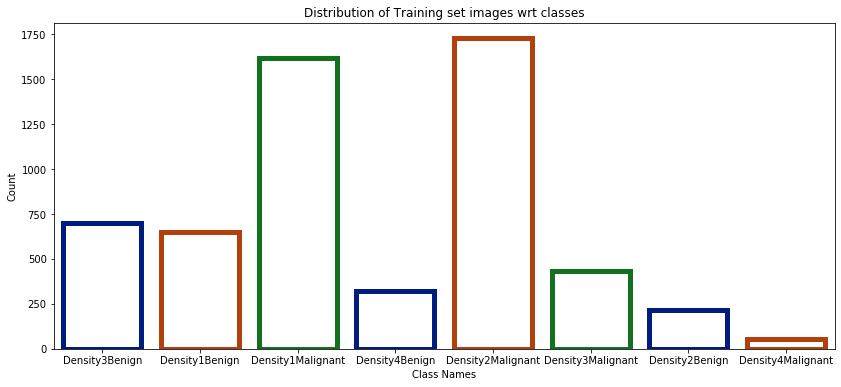

In [7]:
plt.figure(figsize=(14,6))
sns.countplot(x = 'label', data = train_data, facecolor=(0, 0, 0, 0),
                   linewidth=5,
                   edgecolor=sns.color_palette("dark", 3))
plt.xlabel('Class Names')
plt.ylabel('Count')
plt.title('Distribution of Training set images wrt classes')
plt.show()

In [8]:
first_image = train_data['filepaths'][0]

In [9]:
imread(first_image).shape

(224, 224, 3)

Checking out the first image from the training dataset

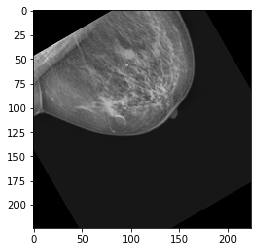

In [10]:
plt.imshow(imread(first_image))

### Checking whether all the images are of same dimensions or not?

In [11]:
dim1 = []
dim2 = []

for i in range(len(train_data)):
    img = imread(train_data['filepaths'][i])
    d1,d2,color = img.shape
    dim1.append(d1)
    dim2.append(d2)

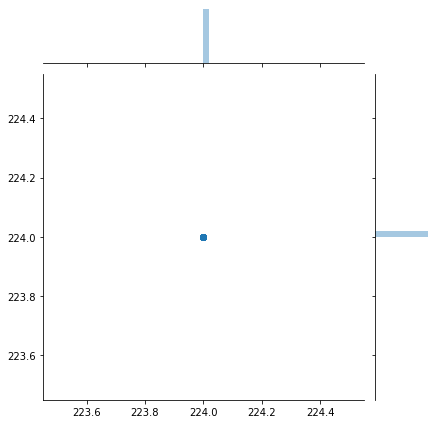

In [12]:
sns.jointplot(dim1, dim2)

### It seems that all the images are of same dimensions, i.e. 224 x 224, so we're gonna take that as the image size.

In [13]:
data = [] 
image_size = 224
for i in range(len(train_data)):

    img_array = cv2.imread(train_data['filepaths'][i], cv2.IMREAD_GRAYSCALE) 
    new_img_array = cv2.resize(img_array, (image_size, image_size)) 
    if train_data['label'][i] == 'Density1Benign':
        data.append([new_img_array, 0])
    elif train_data['label'][i] == 'Density1Malignant':
        data.append([new_img_array, 1])
    elif train_data['label'][i] == 'Density2Benign':
        data.append([new_img_array, 2])
    elif train_data['label'][i] == 'Density2Malignant':
        data.append([new_img_array, 3])
    elif train_data['label'][i] == 'Density3Benign':
        data.append([new_img_array, 4])
    elif train_data['label'][i] == 'Density3Malignant':
        data.append([new_img_array, 5])
    elif train_data['label'][i] == 'Density4Benign':
        data.append([new_img_array, 6])
    elif train_data['label'][i] == 'Density4Malignant':
        data.append([new_img_array, 7])

In [14]:
data[0]

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 4]

In [15]:
np.random.shuffle(data)

In [16]:
x = []
y = []
for image in data:
    x.append(image[0])
    y.append(image[1])

# converting x & y to numpy array as they are list
x = np.array(x)
y = np.array(y)

### Reshaping our images to include 1 colour channel which signifies we're dealing with grey scale images. x.shape[0] gives us the number of training examples, 224 x 224 gives the height and width of image and 1 gives us the number of colour channel. 

In [17]:
x = x.reshape(x.shape[0], 224, 224, 1)

In [18]:
x.shape

(5724, 224, 224, 1)

In [19]:
image_shape = (224, 224, 1)

### Training and validation data split 

In [20]:
X_train, X_val, y_train, y_val = train_test_split(x,y,test_size=0.20, random_state = 42)

### Creating a CNN architecture. 

In [21]:
model = Sequential() # Initialize the sequential model

# Add CNN convolutions with BatchNormalization and MaxPooling2D
# Avoid overfitting with Dropout
model.add(Conv2D(32, kernel_size = (3,3), input_shape= image_shape, padding = 'Same', activation='relu'))
model.add(Conv2D(64, kernel_size = (3,3), padding = 'Same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=1, padding='valid'))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size = (3,3), padding = 'Same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=1, padding='valid'))
model.add(Dropout(0.2))
model.add(Dropout(0.20))
# Convert our matrix to 1-D set of features 
model.add(Flatten())

# Add fully-conected layers
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.20))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.35))
model.add(Dense(8, activation='softmax'))


model.compile(optimizer = Adam(lr = 1e-3), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

filters:- how many filters to apply on an image

kernel_size:- size of the matrix which strides through the whole image

stride:- (x,y) steps while moving the kernel

padding:- Padding is the extra layer we add to the corner of the image to prevent shrinkage and loss of info, such as add a padding of 0 on the outside of the image matrix, so that the corner matrix is also covered more than once while striding. 'same' means padding is present and 'valid' means no padding.

flatten:- flattens our layer, eg, our image is 28x28 so the flattened image will be 28*28=784 pixels.

dropout:- It is a regularization technique which shuts off neurons randomly at each epoch to prevent overfitting.Here we've set rate to 0.3, so it means that 30% of neurons will be shut off randomly while training at each epoch.

batch normalization:- this technique makes neural networks faster and more stable through normalization of the input layer by re-centering and re-scaling.

Adam:- Adam is an optimizer used to change the attributes of your neural network such as weights and learning rate in order to reduce the losses.

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 223, 223, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 223, 223, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 223, 223, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 223, 223, 64)      2

### Visualizing the CNN architecture 

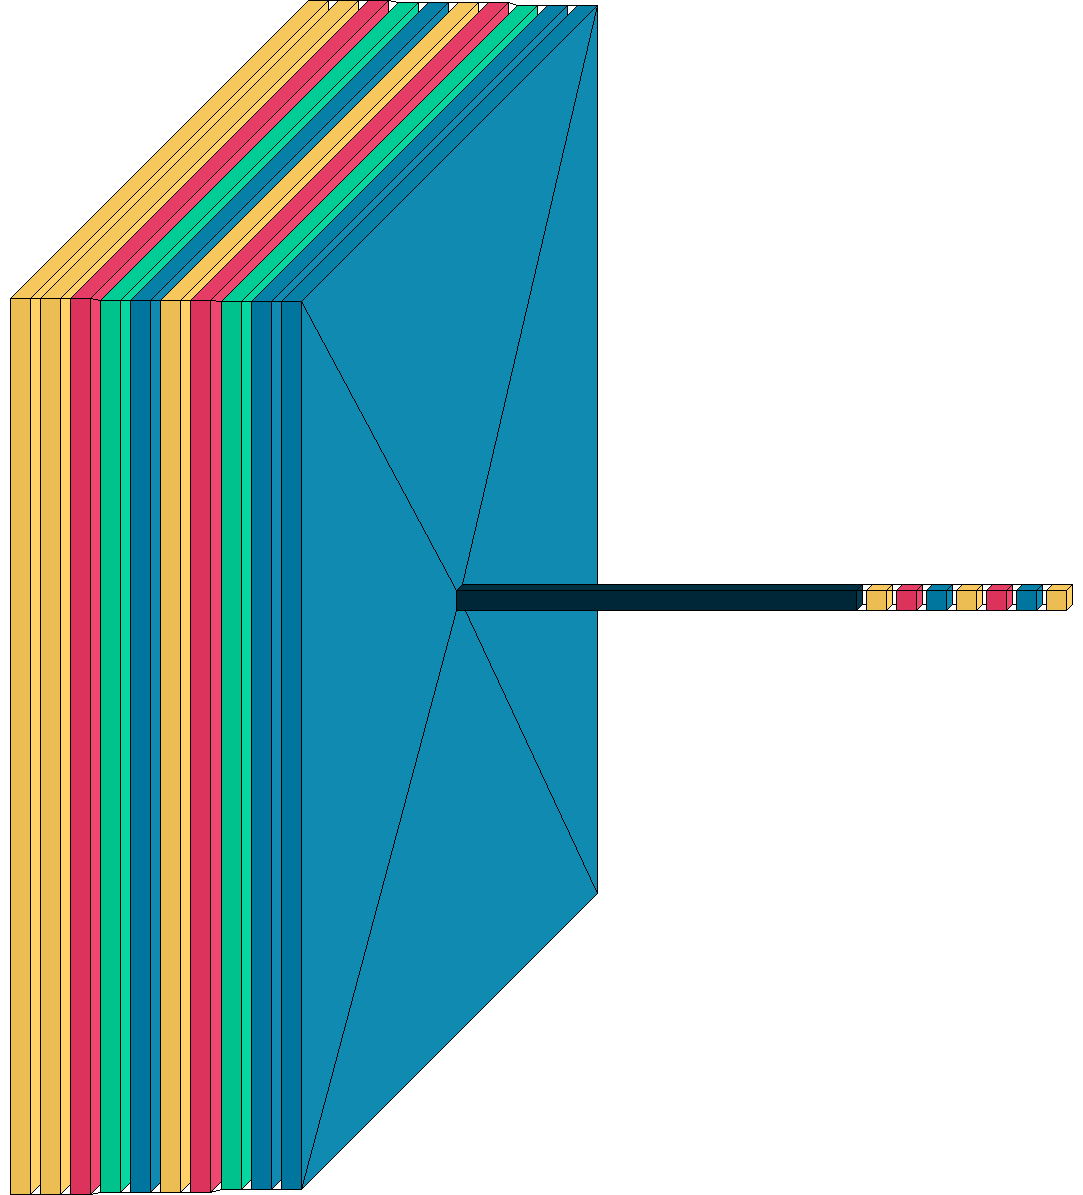

In [23]:
visualkeras.layered_view(model)

In [26]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)

In [27]:
model.fit(X_train, y_train, epochs = 100, batch_size = 16, validation_data = (X_val, y_val), callbacks = [early_stop])

Epoch 1/100
287/287 [==============================] - 255s 773ms/step - loss: 2.6593 - accuracy: 0.1621 - val_loss: 1.8162 - val_accuracy: 0.2777
Epoch 2/100
287/287 [==============================] - 220s 765ms/step - loss: 2.0380 - accuracy: 0.2410 - val_loss: 1.6751 - val_accuracy: 0.3205
Epoch 3/100
287/287 [==============================] - 222s 773ms/step - loss: 1.8717 - accuracy: 0.2768 - val_loss: 1.7413 - val_accuracy: 0.3039
Epoch 4/100
287/287 [==============================] - 222s 773ms/step - loss: 1.7614 - accuracy: 0.2925 - val_loss: 1.6987 - val_accuracy: 0.3886
Epoch 5/100
287/287 [==============================] - 221s 771ms/step - loss: 1.6795 - accuracy: 0.3190 - val_loss: 1.6678 - val_accuracy: 0.3406
Epoch 6/100
287/287 [==============================] - 221s 770ms/step - loss: 1.6960 - accuracy: 0.3201 - val_loss: 2.0534 - val_accuracy: 0.1310
Epoch 7/100
287/287 [==============================] - 221s 770ms/step - loss: 1.4762 - accuracy: 0.4090 - val_loss: 1

In [28]:
metrics = pd.DataFrame(model.history.history)

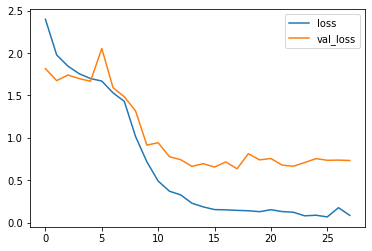

In [29]:
metrics[['loss', 'val_loss']].plot()

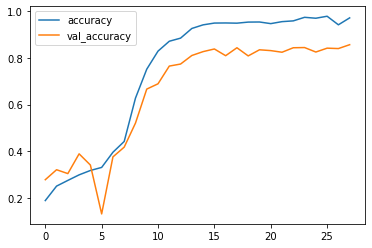

In [30]:
metrics[['accuracy', 'val_accuracy']].plot()

In [31]:
model.evaluate(X_val, y_val)

36/36 [==============================] - 11s 213ms/step - loss: 0.7337 - accuracy: 0.8568


[0.7336766123771667, 0.8567685484886169]

In [53]:
from tensorflow.keras.models import load_model, save_model

In [58]:
classes = {0 : 'Density1Benign' ,
1 : 'Density1Malignant',
2: 'Density2Benign',
3 : 'Density2Malignant',
4 : 'Density3Benign',
5 : 'Density3Malignant',
6 : 'Density4Benign',
7 : 'Density4Malignant'}

### Visualizing the true and predicted classes. Here we used validation data for predicting for now as we don't have the true classes in test dataset. 

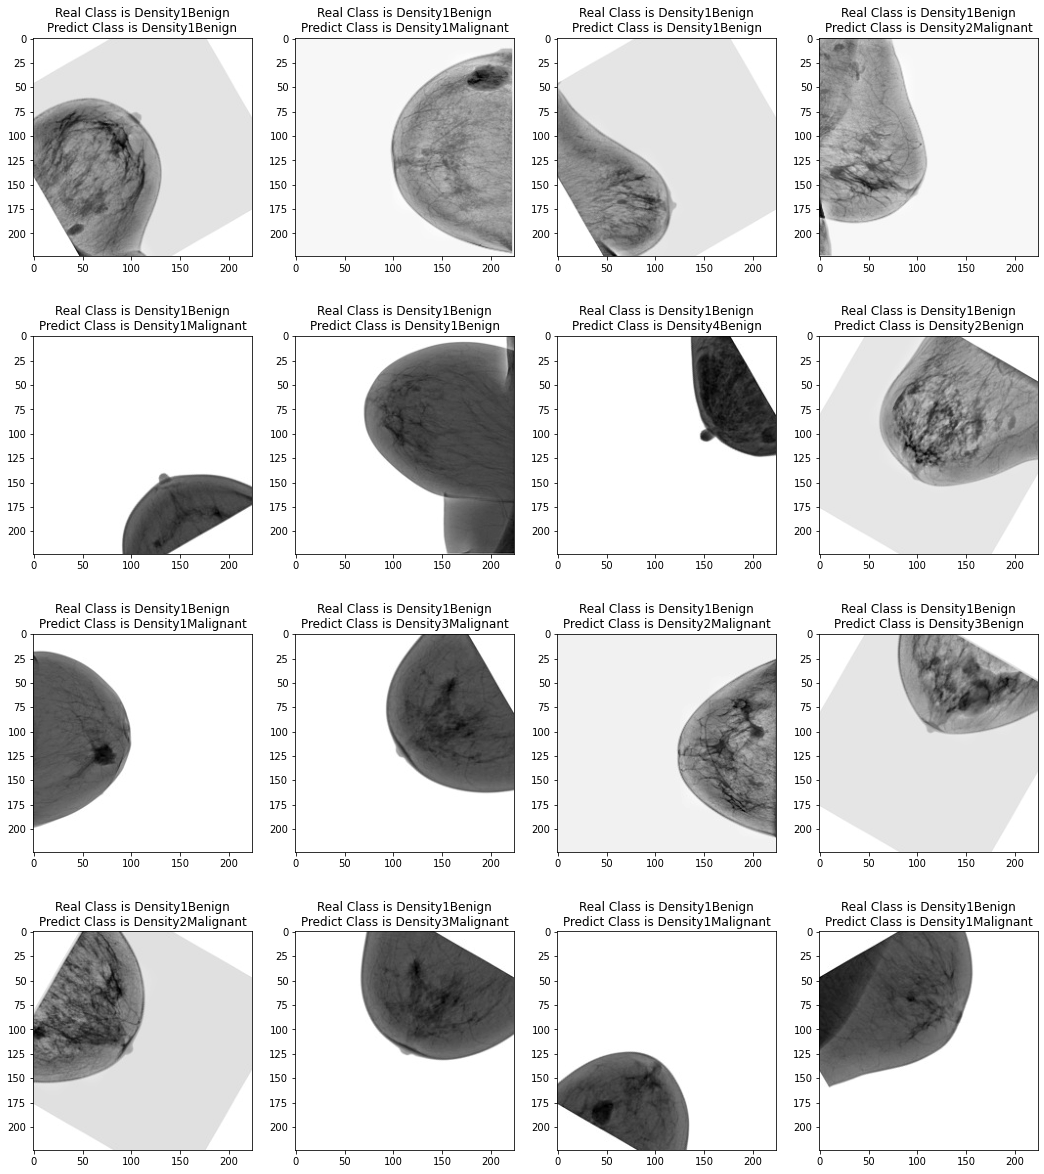

In [62]:
y_pred = model.predict(X_val)
X_test__ = X_val.reshape(X_val.shape[0], 224, 224)

fig, axis = plt.subplots(4, 4, figsize=(18, 21))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='binary')
    ax.set(title = f"Real Class is {classes[y_val[i].argmax()]}\nPredict Class is {classes[y_pred[i].argmax()]}");

### Importing the test dataset 

In [32]:
test_image_order = pd.read_csv("/content/content/mammography_images/Testing_set.csv")
test_image_order.head()

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


In [33]:
file_paths = [[fname, '/content/content/mammography_images/test/' + fname] for fname in test_image_order['filename']]

In [35]:
if len(test_image_order) == len(file_paths):
  print('Number of image names i.e. ', len(test_image_order), 'matches the number of file paths i.e. ', len(file_paths))
else:
  print('Number of image names does not match the number of filepaths')

Number of image names i.e.  1908 matches the number of file paths i.e.  1908


In [36]:
test_images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
test_images.head()

,filename,filepaths
0,Image_1.jpg,/content/content/mammography_images/test/Image...
1,Image_2.jpg,/content/content/mammography_images/test/Image...
2,Image_3.jpg,/content/content/mammography_images/test/Image...
3,Image_4.jpg,/content/content/mammography_images/test/Image...
4,Image_5.jpg,/content/content/mammography_images/test/Image...


In [38]:
test_pixel_data = [] # initialize an empty numpy array
image_size = 224 # image size taken is 100 here. one can take other size too
for i in range(len(test_images)):

  img_array = cv2.imread(test_images['filepaths'][i], cv2.IMREAD_GRAYSCALE) # converting the image to gray scale

  new_img_array = cv2.resize(img_array, (image_size, image_size)) # resizing the image array

  test_pixel_data.append(new_img_array)

In [39]:
test_pixel_data = np.array(test_pixel_data)

In [48]:
test_pixel_data.shape

(1908, 224, 224, 1)

In [42]:
test_pixel_data = test_pixel_data.reshape(test_pixel_data.shape[0], 224, 224, 1)

In [43]:
pred = model.predict(test_pixel_data)

In [49]:
pred[0]

array([2.1665298e-06, 3.0502179e-07, 4.6422265e-05, 2.2618773e-05,
       9.9992025e-01, 4.7267195e-06, 7.0921892e-08, 3.3705844e-06],
      dtype=float32)

In [50]:
predictions = []
for item in pred:
  if np.argmax(item)== 0:
    predictions.append('Density1Benign')
  elif np.argmax(item)== 1:
    predictions.append('Density1Malignant')
  elif np.argmax(item)== 2:
    predictions.append('Density2Benign')
  elif np.argmax(item)== 3:
    predictions.append('Density2Malignant')
  elif np.argmax(item)== 4:
    predictions.append('Density3Benign')
  elif np.argmax(item)== 5:
    predictions.append('Density3Malignant')
  elif np.argmax(item)== 6:
    predictions.append('Density4Benign')
  elif np.argmax(item)== 7:
    predictions.append('Density4Malignant')

In [51]:
res = pd.DataFrame({'filename': test_images['filename'], 'label': predictions}) # prediction is nothing but the final predictions of your model on input features of your new unseen test data
res.to_csv("submission.csv", index = False)

# To download the csv file locally
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>